# Credit Card Fraud Detection using k-Nearest Neighbors

## Exploratory Data Analysis on Credit Card Fraud Dataset

The dataset contains credit card transactions over 2 days by European cardholders. Almost all predictors (features) have been anonymized for obvious reasons. There is a need to understand the data before it can be worked upon.



### 1. Import Data

In [0]:
# author: Shamli Singh

In [1]:
# import basic libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# store dataset to pandas dataframe
path = "/content/drive/My Drive/CS 271/Project/Data/creditcardfraud/creditcard.csv"
data = pd.read_csv(path)

In [4]:
# get to know the data
data.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264901,161647.0,2.062174,0.059165,-1.720997,0.428217,0.325334,-0.838759,0.089363,-0.142847,0.676194,-0.351067,-0.705024,-0.476907,-1.168305,-0.593427,0.385327,0.308474,0.608471,-0.253935,-0.019892,-0.239979,-0.370825,-1.017357,0.363513,0.475057,-0.318035,0.179340,-0.067636,-0.033275,2.49,0
221669,142652.0,-0.447491,0.042820,1.155978,-0.556050,-1.589706,2.210078,3.770266,-1.795128,0.448046,1.458105,-1.571867,-1.550705,-1.156615,-1.893045,-1.423487,-2.513832,-0.505774,1.234988,-0.962550,-0.836474,-0.532340,0.741105,-0.833609,0.644005,0.295405,-0.468947,-1.052344,-1.442305,508.28,0
119280,75393.0,-1.447423,1.644109,0.651114,-0.472409,0.269761,-0.312991,0.709396,-0.091531,0.586889,1.352510,0.913444,-0.176608,-0.803586,-0.656685,0.461748,0.643583,-0.597825,0.587291,0.365227,0.574506,-0.429562,-0.830271,-0.013161,-0.450259,0.047624,0.069313,0.240182,0.106291,9.84,0
45718,42469.0,-1.982802,-0.066287,1.726109,-2.434436,-0.841375,-1.323436,-0.442325,0.631218,1.752330,-1.670364,-1.057194,-0.335387,-1.790753,0.156740,0.785180,0.046762,-0.162972,0.497870,-0.147815,-0.099850,0.080280,0.441723,0.062928,0.384577,0.718023,0.027021,0.322982,0.068921,5.00,0
189922,128612.0,-2.334753,2.410573,-3.152297,-0.047362,-0.088721,-0.447415,-0.567663,1.415079,0.062499,-1.085613,0.236191,0.918429,0.000884,-1.145384,-1.034218,0.708604,1.844649,1.388996,0.602720,-0.553715,0.154995,-0.171054,0.060831,0.008591,-0.066902,-0.423668,-1.463622,-0.092754,15.00,0


In [5]:
print(data.shape)

(284807, 31)


In [6]:
print(data.describe())

                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]


### 2. Verify the imbalance

In [7]:
frauds = data[data['Class'] == 1]
valids = data[data['Class'] == 0]
fraction = len(frauds) / float(len(valids))
print("Fraud cases are {}% of total {} cases".format(fraction*100, len(frauds)+len(valids)))
print("Fraud cases = {}, Valid transactions = {}".format(len(frauds), len(valids)))

Fraud cases are 0.17304750013189596% of total 284807 cases
Fraud cases = 492, Valid transactions = 284315


### 3. Learn about the data


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
# check if any variables are missing data
data.isnull().any().any()

False

In [10]:
# check amounts of valid/invalid transactions
valids.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

The average transaction is around USD 88.29, while the maximum transaction is of USD 25,691.16. It is important to check the distribution of the transactions. At this time, we can assume that the odd larger transactions could be fraudulent.

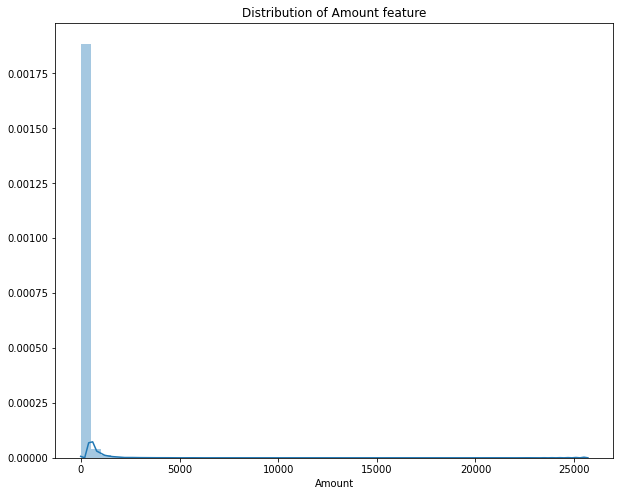

In [11]:
# check the distribution of amount feature
plt.figure(figsize=(10, 8))
plt.title('Distribution of Amount feature')
sns.distplot(data.Amount)

As visible in the plot, the distribution is heavily right-skewed, meaning we can definitely assume that the maximum genuine transactions have low amount.

### 4. Correlation matrix
Correlation matrix gives a graphical idea of how features are correlate with each other. It can be visualized as a heatmap that can help us deciding which features will be most relevant for prediction.

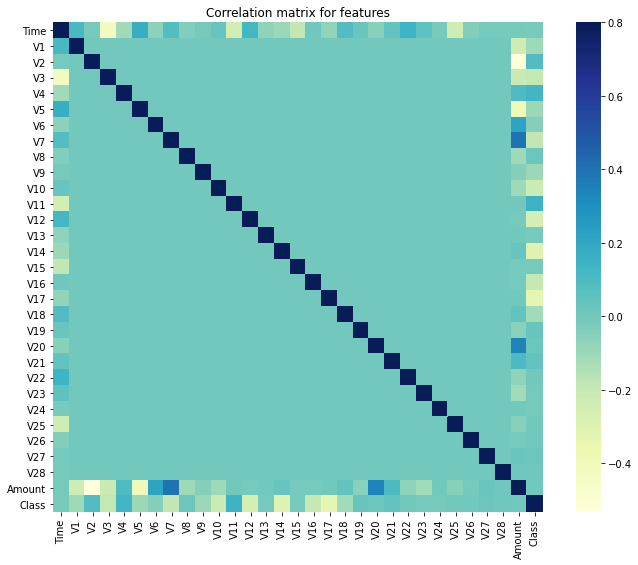

In [12]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 9))
plt.title('Correlation matrix for features')
# plot the matrix as a heatmap
sns.heatmap(corr_matrix, vmax=0.8, cmap='YlGnBu', square=True)
plt.show()

We see that the strongest color is seen along the diagonal, which means the features are highly correlated with themselves; this is an ideal case. Most of the features do not correlate to each other. Some features do have either positive or negative correlations. e.g. features *V2*, *V5*, *V1* and *V3* are highest negatively correlated (in descending order) with the feature *Amount*. Whereas *V7*, *V20* and *V6* are the highest positively correlated (in descending order) features with *Amount*.

It is important to note that the correlation is low for so many features. This could be because the features are principal components as the data was prepared using PCA.

### 5. Experiments using k-Nearest Neighbors

We need to determine the value of *k* before running a model. The default value to start from is 5




#### a. Basic kNN classifier with default *k=5*

In [0]:
# separate features and output of the dataset
X = data.drop(labels='Class', axis=1)   # the features
Y = data.loc[:, 'Class']    # the classification

# library imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
import datetime as dt

In [23]:
from sklearn.neighbors import KNeighborsClassifier

accuracy = []
precision = []
recall = []
auc = []
f1 = []
balanced = []
conf_mat = []
roc = []
pr = []
neighbors = [5, 10, 15, 20, 25, 50]
models = []

for n in neighbors:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4, stratify=Y)
    knn = KNeighborsClassifier(n_neighbors=n, p=2)  # p=2 for Euclidean distance
    # train
    knn.fit(X_train, Y_train)
    # test
    Y_pred = knn.predict(X_test)
    models.append(knn)
    print("kNN with k = {}".format(n))
    print(classification_report(Y_test, Y_pred))
    # score
    accuracy.append(accuracy_score(Y_test, Y_pred))
    precision.append(precision_score(Y_test, Y_pred))
    recall.append(recall_score(Y_test, Y_pred))
    auc.append(roc_auc_score(Y_test, Y_pred))
    balanced.append(balanced_accuracy_score(Y_test, Y_pred))
    f1.append(f1_score(Y_test, Y_pred))
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc.append([fpr, tpr])
    p, r, _ = precision_recall_curve(Y_test, Y_pred)
    pr.append([p, r])
    conf_mat.append(confusion_matrix(Y_test, Y_pred))   # for confusion matrix later
    print(conf_mat)
    print("----------")

kNN with k = 5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.07      0.13        98

    accuracy                           1.00     56962
   macro avg       1.00      0.54      0.57     56962
weighted avg       1.00      1.00      1.00     56962

[array([[56864,     0],
       [   91,     7]])]
----------
kNN with k = 10
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.01      0.02        98

    accuracy                           1.00     56962
   macro avg       1.00      0.51      0.51     56962
weighted avg       1.00      1.00      1.00     56962

[array([[56864,     0],
       [   91,     7]]), array([[56864,     0],
       [   97,     1]])]
----------
kNN with k = 15
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[array([[56864,     0],
       [   91,     7]]), array([[56864,     0],
       [   97,     1]]), array([[56864,     0],
       [   95,     3]]), array([[56864,     0],
       [   98,     0]])]
----------
kNN with k = 25
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[array([[56864,     0],
       [   91,     7]]), array([[56864,     0],
       [   97,     1]]), array([[56864,     0],
       [   95,     3]]), array([[56864,     0],
       [   98,     0]]), array([[56864,     0],
       [   98,     0]])]
----------
kNN with k = 50
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[array([[56864,     0],
       [   91,     7]]), array([[56864,     0],
       [   97,     1]]), array([[56864,     0],
       [   95,     3]]), array([[56864,     0],
       [   98,     0]]), array([[56864,     0],
       [   98,     0]]), array([[56864,     0],
       [   98,     0]])]
----------


In [24]:
# display results
for i in range(len(neighbors)):
    print("Basic k-Nearest Neighbors Classifier with k = {}".format(neighbors[i]))
    print("Accuracy score = {}".format(accuracy[i]))
    print("Precision score = {}".format(precision[i]))
    print("Recall score = {}".format(recall[i]))
    print("AUC score = {}".format(auc[i]))
    print("Balanced accuracy score = {}".format(balanced[i]))
    print("F1 score = {}".format(f1[i]))
    print("----------")

Basic k-Nearest Neighbors Classifier with k = 5
Accuracy score = 0.9984024437344194
Precision score = 1.0
Recall score = 0.07142857142857142
AUC score = 0.5357142857142857
Balanced accuracy score = 0.5357142857142857
F1 score = 0.13333333333333333
----------
Basic k-Nearest Neighbors Classifier with k = 10
Accuracy score = 0.9982971103542713
Precision score = 1.0
Recall score = 0.01020408163265306
AUC score = 0.5051020408163265
Balanced accuracy score = 0.5051020408163265
F1 score = 0.020202020202020204
----------
Basic k-Nearest Neighbors Classifier with k = 15
Accuracy score = 0.9983322214809873
Precision score = 1.0
Recall score = 0.030612244897959183
AUC score = 0.5153061224489796
Balanced accuracy score = 0.5153061224489796
F1 score = 0.05940594059405941
----------
Basic k-Nearest Neighbors Classifier with k = 20
Accuracy score = 0.9982795547909132
Precision score = 0.0
Recall score = 0.0
AUC score = 0.5
Balanced accuracy score = 0.5
F1 score = 0.0
----------
Basic k-Nearest Neigh

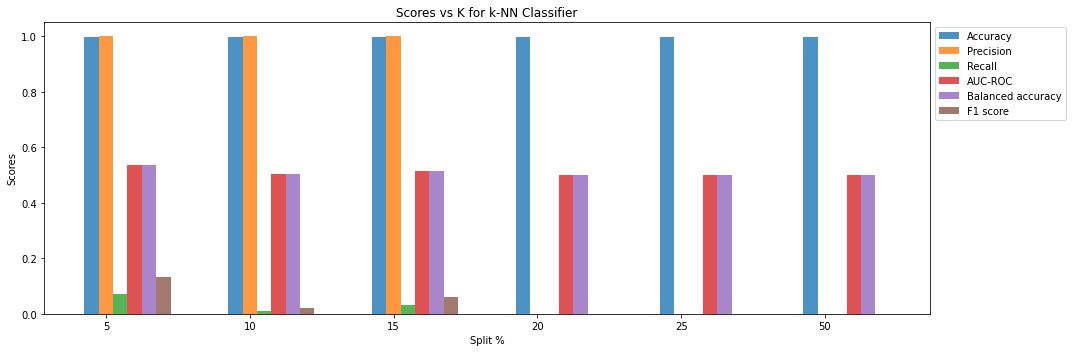

In [25]:
# plot for better visualization
x = np.arange(len(neighbors))
width = 0.1
opacity = 0.8
# fig, ax = plt.subplots()

# vertical bar graph
plt.figure(figsize=(15, 5))
bar1 = plt.bar(x, accuracy, width, alpha=opacity, label='Accuracy')
bar2 = plt.bar(x+width, precision, width, alpha=opacity, label='Precision')
bar3 = plt.bar(x+(2*width), recall, width, alpha=opacity, label='Recall')
bar4 = plt.bar(x+(3*width), auc, width, alpha=opacity, label='AUC-ROC')
bar5 = plt.bar(x+(4*width), balanced, width, alpha=opacity, label='Balanced accuracy')
bar5 = plt.bar(x+(5*width), f1, width, alpha=opacity, label='F1 score')

plt.xlabel('Split %')
plt.ylabel('Scores')
plt.title('Scores vs K for k-NN Classifier')
plt.xticks(x+width, neighbors)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.tight_layout()
plt.show()

We tried all multiples of 5 from 5 to 50 as our *k*. In terms of the scores and precision, 5, 10 and 15 seem to work well.

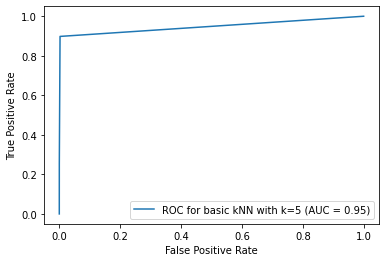

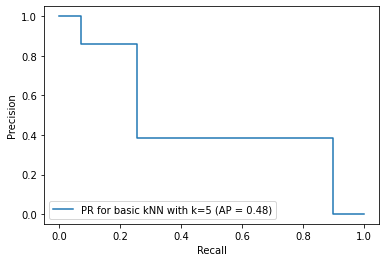

In [39]:
# plot curves
# using existing model of k=5 from previous code snippet
# roc curve
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
plot_roc_curve(models[0], X_test, Y_test, name='ROC for basic kNN with k=5')
plt.show()
# pr curve
plot_precision_recall_curve(models[0], X_test, Y_test, name='PR for basic kNN with k=5')
plt.show()

For our k=5, the accuracy and AUC-ROC are good at 99.8% and 0.95 respectively, but AUC-PR and balanced accuracy are abysmal at 0.48 and 53.5% respectively.

#### b. Using grid search for optimal value of *k*
We try grid search on the data to find an optimal value of k. Note that this works using cross-validation technique, and the score obtained is the mean of the accuracies of each fold in the cross-validation.

##### i. Using *k=50*

In [27]:
# import
from sklearn.model_selection import GridSearchCV

# dictionary of possible values to try for k
grid = {'n_neighbors': np.arange(5, 50, 5)}

gknn = KNeighborsClassifier()
knn_gscv = GridSearchCV(gknn, grid, cv=5)
# train
knn_gscv.fit(X, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [28]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 45}

In [29]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.5849278721969732

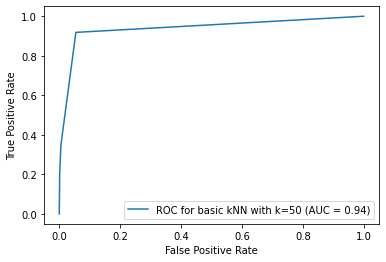

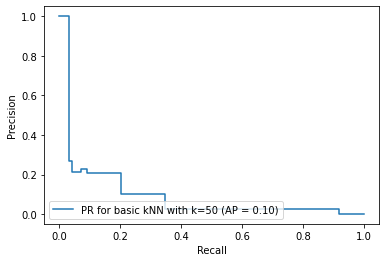

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
# roc curve
plot_roc_curve(models[5], X_test, Y_test, name='ROC for basic kNN with k=50')
plt.show()
# pr curve
plot_precision_recall_curve(models[5], X_test, Y_test, name='PR for basic kNN with k=50')
plt.show()

For our *k=50*, similar to k=5, the accuracy and AUC-ROC are good at 99.8% and 0.94 respectively, but AUC-PR and balanced accuracy are really bad at 0.1 and 50% respectively.

##### ii. Using *k=100*

In [30]:
# dictionary of new possible values to try for k, since last code snippet says k=45 is good
grid = {'n_neighbors': np.arange(50, 101, 10)}

gknn = KNeighborsClassifier()
knn_gscv = GridSearchCV(gknn, grid, cv=5)
# train
knn_gscv.fit(X, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 50,  60,  70,  80,  90, 100])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [31]:
#check top performing n_neighbors value again
knn_gscv.best_params_

{'n_neighbors': 100}

In [32]:
#check mean score for the top performing value of n_neighbors again
knn_gscv.best_score_

0.7926225762451468

Here our accuracy score has decreased from earlier 99.8%

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4, stratify=Y)
knn = KNeighborsClassifier(n_neighbors=100, p=2)  # p=2 for Euclidean distance
# train
knn.fit(X_train, Y_train)
# test
Y_pred = knn.predict(X_test)
models.append(knn)
print("kNN with k = {}".format(100))
print(classification_report(Y_test, Y_pred))
# score
accuracy.append(accuracy_score(Y_test, Y_pred))
precision.append(precision_score(Y_test, Y_pred))
recall.append(recall_score(Y_test, Y_pred))
auc.append(roc_auc_score(Y_test, Y_pred))
balanced.append(balanced_accuracy_score(Y_test, Y_pred))
f1.append(f1_score(Y_test, Y_pred))
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc.append([fpr, tpr])
p, r, _ = precision_recall_curve(Y_test, Y_pred)
pr.append([p, r])
conf_mat.append(confusion_matrix(Y_test, Y_pred))   # for confusion matrix later
print(conf_mat)
print("----------")

kNN with k = 100
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[array([[56864,     0],
       [   91,     7]]), array([[56864,     0],
       [   97,     1]]), array([[56864,     0],
       [   95,     3]]), array([[56864,     0],
       [   98,     0]]), array([[56864,     0],
       [   98,     0]]), array([[56864,     0],
       [   98,     0]]), array([[56864,     0],
       [   98,     0]])]
----------


In [47]:
print("Basic k-Nearest Neighbors Classifier with k = {}".format(100))
print("Accuracy score = {}".format(accuracy[6]))
print("Precision score = {}".format(precision[6]))
print("Recall score = {}".format(recall[6]))
print("AUC score = {}".format(auc[6]))
print("Balanced accuracy score = {}".format(balanced[6]))
print("F1 score = {}".format(f1[6]))
neighbors.append(100)

Basic k-Nearest Neighbors Classifier with k = 100
Accuracy score = 0.9982795547909132
Precision score = 0.0
Recall score = 0.0
AUC score = 0.5
Balanced accuracy score = 0.5
F1 score = 0.0


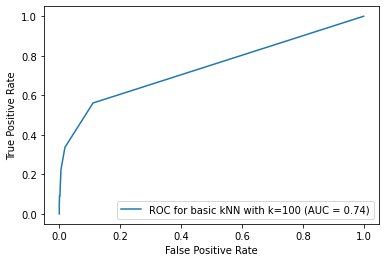

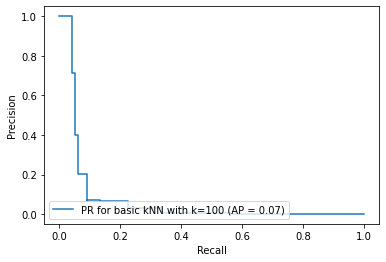

In [48]:
plot_roc_curve(models[6], X_test, Y_test, name='ROC for basic kNN with k=100')
plt.show()
# pr curve
plot_precision_recall_curve(models[6], X_test, Y_test, name='PR for basic kNN with k=100')
plt.show()

For our *k=100*, just like k=50, the accuracy is good at 99.8%. We see a dip in AUC-ROC to 0.74, but AUC-PR and balanced accuracy are horrible bad at 0.07 and again 50% respectively.

##### iii. Using *k=150*

In [33]:
# dictionary of new possible values as a last try for k, since last code snippet says k=100 is good
grid = {'n_neighbors': np.arange(100, 251, 50)}

gknn = KNeighborsClassifier()
knn_gscv = GridSearchCV(gknn, grid, cv=5)
# train
knn_gscv.fit(X, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([100, 150, 200, 250])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [34]:
#check top performing n_neighbors value once more
knn_gscv.best_params_

{'n_neighbors': 150}

In [35]:
#check mean score for the top performing value of n_neighbors once more
knn_gscv.best_score_

0.9982725144432208

This last experiment clears up *k* for us a bit. We get a mean accuracy score of 99.8% for *k=150*, which is amazing after previous dip to 79% at k=100. So we will try out *k=150* too.

In [36]:
# o: optimal
X_o_train, X_o_test, Y_o_train, Y_o_test = train_test_split(X, Y, test_size=0.2, random_state=4, stratify=Y)
knn_o = KNeighborsClassifier(n_neighbors=150, p=2)  # p=2 for Euclidean distance, k=150 determined earlier
# train
knn_o.fit(X_o_train, Y_o_train)
# test
Y_o_pred = knn_o.predict(X_o_test)
print("kNN with k = 150")
print(classification_report(Y_o_test, Y_o_pred))
# score
accuracy_o = accuracy_score(Y_o_test, Y_o_pred)
precision_o = precision_score(Y_o_test, Y_o_pred)
recall_o = recall_score(Y_o_test, Y_o_pred)
auc_o = roc_auc_score(Y_o_test, Y_o_pred)
balanced_o = balanced_accuracy_score(Y_o_test, Y_o_pred)
f1_o = f1_score(Y_o_test, Y_o_pred)
fpr_o, tpr_o, _ = roc_curve(Y_o_test, Y_o_pred)
p_o, r_o, _ = precision_recall_curve(Y_o_test, Y_o_pred)
conf_mat_o = confusion_matrix(Y_o_test, Y_o_pred)   # for confusion matrix later
print(conf_mat_o)

kNN with k = 150
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[56864     0]
 [   98     0]]


In [37]:
# display results
print("Basic k-Nearest Neighbors Classifier with k = 150")
print("Accuracy score = {}".format(accuracy_o))
print("Precision score = {}".format(precision_o))
print("Recall score = {}".format(recall_o))
print("AUC score = {}".format(auc_o))
print("Balanced accuracy score = {}".format(balanced_o))
print("F1 score = {}".format(f1_o))

Basic k-Nearest Neighbors Classifier with k = 150
Accuracy score = 0.9982795547909132
Precision score = 0.0
Recall score = 0.0
AUC score = 0.5
Balanced accuracy score = 0.5
F1 score = 0.0


Despite a high accuracy score of 99.8% again, we get a really poor precision and recall. Our balanced accuracy also stands at 50%. Let's look at the ROC and PR curves.

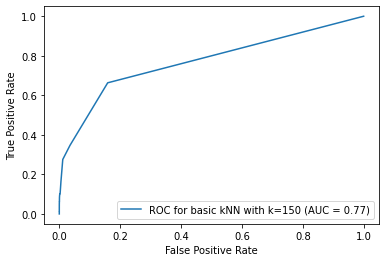

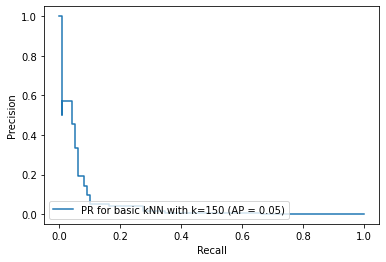

In [40]:
# plots
plot_roc_curve(knn_o, X_o_test, Y_o_test, name='ROC for basic kNN with k=150')
plt.show()
plot_precision_recall_curve(knn_o, X_o_test, Y_o_test, name='PR for basic kNN with k=150')
plt.show()

The AUC-ROC is 0.77 which is not too bad, but the AUC-PR has suffered by falling to 0.05.

### 6. Analysis of results

We need to analyze the results we have obtained in the notebook above.

In [52]:
# f: final
f_acc = [accuracy[0], accuracy[5], accuracy[6], accuracy_o]
f_pre = [precision[0], precision[5], precision[6], precision_o]
f_rec = [recall[0], recall[5], recall[6], recall_o]
f_auc = [0.95, 0.94, 0.74, 0.77]  # obtained from curves
f_ap = [0.48, 0.1, 0.07, 0.05]   # obtained from curves
f_bal = [balanced[0], balanced[5], balanced[6], balanced_o]
f_f1 = [f1[0], f1[5], f1[6], f1_o]
f_names = ['Accuracy', 'Precision', 'Recall', 'AUC-ROC', 'AUC-PR', 'Balanced accuracy', 'F1 score']
f_exp = ['k = 5', 'k = 50', 'k = 100', 'k = 150']

print(f_exp)
print("Accuracy: {}".format(f_acc))
print("Precision: {}".format(f_pre))
print("Recall: {}".format(f_rec))
print("AUC-ROC: {}".format(f_auc))
print("AUC-PR: {}".format(f_ap))
print("Balanced accuracy: {}".format(f_bal))
print("F1: {}".format(f_f1))

['k = 5', 'k = 50', 'k = 100', 'k = 150']
Accuracy: [0.9984024437344194, 0.9982795547909132, 0.9982795547909132, 0.9982795547909132]
Precision: [1.0, 0.0, 0.0, 0.0]
Recall: [0.07142857142857142, 0.0, 0.0, 0.0]
AUC-ROC: [0.95, 0.94, 0.74, 0.77]
AUC-PR: [0.48, 0.1, 0.07, 0.05]
Balanced accuracy: [0.5357142857142857, 0.5, 0.5, 0.5]
F1: [0.13333333333333333, 0.0, 0.0, 0.0]


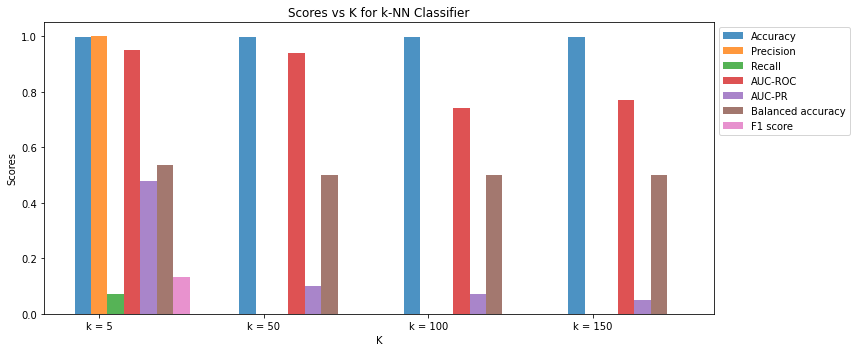

In [51]:
# plot for better visualization
x = np.arange(len(f_exp))
width = 0.1
opacity = 0.8

# vertical bar graph
plt.figure(figsize=(12, 5))
bar1 = plt.bar(x, f_acc, width, alpha=opacity, label=f_names[0])
bar2 = plt.bar(x+width, f_pre, width, alpha=opacity, label=f_names[1])
bar3 = plt.bar(x+(2*width), f_rec, width, alpha=opacity, label=f_names[2])
bar4 = plt.bar(x+(3*width), f_auc, width, alpha=opacity, label=f_names[3])
bar5 = plt.bar(x+(4*width), f_ap, width, alpha=opacity, label=f_names[4])
bar6 = plt.bar(x+(5*width), f_bal, width, alpha=opacity, label=f_names[5])
bar7 = plt.bar(x+(6*width), f_f1, width, alpha=opacity, label=f_names[6])

plt.xlabel('K')
plt.ylabel('Scores')
plt.title('Scores vs K for k-NN Classifier')
plt.xticks(x+width, f_exp)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.tight_layout()
plt.show()

From all the results consolidated above, it looks like k=5 works well with this problem. We also tried k=150 due to a false alarm, but the end result is poor, as per the chart plotted above.

It is evident that for this problem, k-Nearest Neighbors at k=5 will work nicely, even though it is not a desired case.